In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#Let's read in the census person dataset - pppub19.csv
ppdf = pd.read_csv('../data/pppub19_updated.csv')
ppdf.head()

,PERIDNUM,GESTCEN,PH_SEQ,GTCBSA,P_SEQ,A_LINENO,PF_SEQ,PHF_SEQ,OED_TYP1,OED_TYP2,...,I_DISVL1,I_DISVL2,I_SURVL1,I_SURVL2,MIG_CBST,MIG_DSCP,DEP_STAT,FILEDATE,FILESTAT,MMYY
0,1.000690e+20,11,4,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,110419,5,32019
1,3.999400e+21,11,6,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,110419,5,32019
2,9.119340e+21,11,7,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,110419,5,32019
3,1.410320e+21,11,8,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,110419,6,32019
4,1.410320e+21,11,8,0,2,2,1,1,0,0,...,0,0,0,0,0,0,0,110419,5,32019


In [21]:
#Let's start by limiting what columns we're working with
ppdf_filtered = ppdf[['PERIDNUM', 'GTCBSA', 'A_AGE', 'PTOTVAL']]
ppdf_filtered

,PERIDNUM,GTCBSA,A_AGE,PTOTVAL
0,1.000690e+20,0,21,18000
1,3.999400e+21,0,85,21780
2,9.119340e+21,0,61,12000
3,1.410320e+21,0,73,10727
4,1.410320e+21,0,37,12000
...,...,...,...,...
180096,5.977500e+21,46520,45,30001
180097,5.977500e+21,46520,15,0
180098,5.977500e+21,46520,14,0
180099,5.789400e+21,46520,57,15000


In [22]:
#Then we can narrow it down to the Nashville-Davidson-Murfreesboro-Franklin CBSA - 34980
#CBSA sourced from https://www.uspto.gov/web/offices/ac/ido/oeip/taf/cls_cbsa/cbsa_countyassoc.htm
ppdf_filtered = ppdf_filtered.loc[ppdf_filtered['GTCBSA'] == 34980]
ppdf_filtered

,PERIDNUM,GTCBSA,A_AGE,PTOTVAL
98989,7.806710e+20,34980,71,9600
98990,7.649700e+21,34980,33,33552
98991,7.649700e+21,34980,31,204695
98992,1.164640e+21,34980,58,35610
98993,7.925700e+21,34980,80,49586
...,...,...,...,...
100000,1.206770e+20,34980,31,66000
100001,1.206770e+20,34980,12,0
100002,7.602500e+21,34980,34,87650
100003,7.602500e+21,34980,31,60050


[]

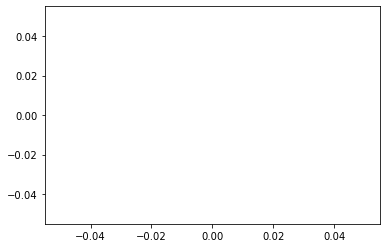

In [27]:
plt.plot(kind='scatter', xaxis = 'A_AGE', yaxis = 'PTOTVAL')